In [1]:
import pandas as pd
from pandas import json_normalize

import datetime
import numpy as np
import json
import requests
import urllib.request

from datetime import datetime
import matplotlib.pyplot as plt
from scipy import interpolate
import statsmodels.api as sm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter


In [3]:
url =  "https://deribit.com/api/v2/public/get_instruments?currency=BTC&kind=option&expired=false"
with urllib.request.urlopen(url) as url:
    get_inst_names = json.loads(url.read().decode())

inst_names = pd.DataFrame(get_inst_names['result'])#.set_index('instrument_name')
inst_names['creation_date'] = pd.to_datetime(inst_names['creation_timestamp'], unit='ms')
inst_names['expiration_date'] = pd.to_datetime(inst_names['expiration_timestamp'], unit='ms')


api_data_list = []

for x in inst_names['instrument_name']:
    url = f'https://www.deribit.com/api/v2/public/get_order_book?instrument_name={x}&kind=option&expired=false'
    with urllib.request.urlopen(url) as response:
        api_data = json.loads(response.read().decode())

    api_data_df = pd.DataFrame([api_data])
    api_data_list.append(api_data_df)

all_data = pd.concat(api_data_list, ignore_index=True)
all_data = pd.json_normalize(all_data['result'])

In [4]:
all_data

,estimated_delivery_price,best_bid_amount,best_ask_amount,underlying_index,bid_iv,ask_iv,underlying_price,mark_iv,best_bid_price,best_ask_price,...,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high
0,65237.11,40.0,40.0,SYN.BTC-20JUN24,0.00,284.21,65237.4889,85.26,0.1080,0.1130,...,0.43147,-0.00080,0.00002,0.0,1.00000,0.00,0.0,NaN,NaN,NaN
1,65237.11,0.0,0.6,SYN.BTC-20JUN24,0.00,174.82,65237.4889,85.26,0.0000,0.0001,...,0.00000,-0.00006,0.00002,0.0,0.00000,6.54,1.0,0.0,0.0001,0.0001
2,65238.29,40.0,40.0,SYN.BTC-20JUN24,0.00,271.44,65241.9297,85.26,0.0925,0.0985,...,0.43890,-0.02498,0.00059,0.0,0.99999,0.00,0.0,NaN,NaN,NaN
3,65238.43,0.0,0.1,SYN.BTC-20JUN24,0.00,152.17,65243.0241,85.26,0.0000,0.0001,...,0.00000,-0.00232,0.00058,0.0,-0.00001,9.77,1.5,0.0,0.0001,0.0001
4,65238.23,40.0,40.0,SYN.BTC-20JUN24,0.00,232.29,65243.1640,85.22,0.0770,0.0830,...,0.44627,-0.43812,0.01028,0.0,0.99985,0.00,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,65179.40,0.0,0.0,BTC-28MAR25,0.00,0.00,70795.1000,74.38,0.0000,0.0000,...,-1662.13489,-12.12927,91.73455,0.0,-0.92075,0.00,0.0,NaN,NaN,NaN
866,65180.30,8.0,8.0,BTC-28MAR25,74.43,76.87,70788.1300,75.69,0.0120,0.0145,...,24.71582,-9.77220,72.63077,0.0,0.05856,9885.58,11.8,16.0,0.0125,0.0145
867,65181.85,0.0,0.0,BTC-28MAR25,0.00,0.00,70788.6500,75.69,0.0000,0.0000,...,-1901.74381,-9.77240,72.63230,0.0,-0.94143,0.00,0.0,NaN,NaN,NaN
868,65181.26,5.6,8.0,BTC-28MAR25,76.60,79.33,70789.8400,77.95,0.0075,0.0095,...,16.39224,-7.19221,51.90587,0.0,0.03850,1348.07,2.3,0.0,0.0090,0.0090


In [5]:
data = all_data
exclude_columns = ['instrument_name', 'underlying_index']
data = data.apply(lambda x: pd.to_numeric(x, errors='ignore') if x.name not in exclude_columns else x)


strike = []
for index, i in enumerate(data['instrument_name']):
    i = float(i.split('-')[2])
    strike.append(i)
data["strikePx"] = strike

maturity = []
for index, i in enumerate(data['instrument_name']):
    i = i.split('-')[1]
    i = pd.to_datetime(i, unit ='ns')
    maturity.append(i)
data["maturity"] = maturity

days_to_maturity = []
for index, i in enumerate(data['maturity']):
    i = (i - datetime.today()).days
    days_to_maturity.append(i)
data["days_to_maturity"] = days_to_maturity


# Moneyness:  'underlying price' is the price of underlying Futures
data['moneyness'] = data['strikePx'].astype(float)/ data['underlying_price'].astype(float)

#log Moneyness, making extreme values less extreme
#data['moneyness'] = np.log(data['strikePx'].astype(float)/ data['fwdPx'].astype(float)) 


data.loc[data['instrument_name'].str.contains('-P'), 'moneyness'] = data.loc[data['instrument_name'].str.contains('-P'), 'moneyness'] * -1

data = data.sort_values(['days_to_maturity','strikePx']).query('days_to_maturity > 0')
all_calls = data[data['instrument_name'].str.contains('-C')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')
all_puts = data[data['instrument_name'].str.contains('-P')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')

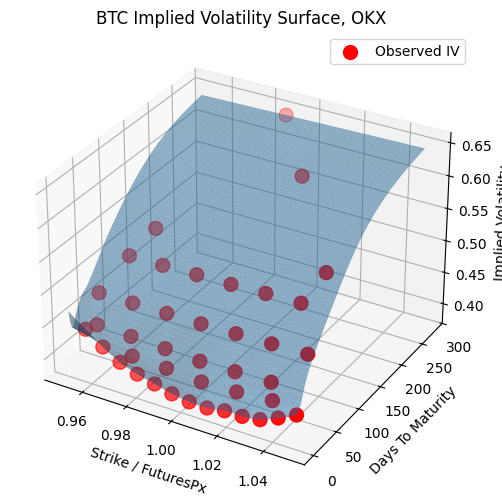

In [6]:
#%matplotlib notebook 

# Interpolate implied volatility using a cubic spline
'''
Cubic Spline interpolation uses cubic polynominals to interpolate between data points

'''

def plot_iv_surf(x,y,z,x2=None,y2=None,z2=None,label=''):
    fig = plt.figure(3, figsize=(6,6))
    ax=plt.axes(projection='3d')
    ax.set_title('BTC Implied Volatility Surface, OKX')
    ax.set_zlabel('Implied Volatility')
    plt.xlabel('Strike / FuturesPx')
    plt.ylabel('Days To Maturity')
    #ax.zaxis.set_major_formatter(FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
    if z2 is not None:
        ax.scatter3D(x2,y2,z2, c='r', s=100,label=label)
    ax.plot_surface(x, y, z, rstride=1, cstride=1,alpha=0.5)
    ax.legend()
    

x = data['moneyness']
y = data['days_to_maturity']
z = data['mark_iv']/100

X,Y = np.meshgrid(np.linspace(.95,1.05,99),np.linspace(1,np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='cubic')

xyz = pd.DataFrame({'x':x,'y':y,'z':z})
xyz = xyz.query('x>0.95 & x<1.05')
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV')

iv_df = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))

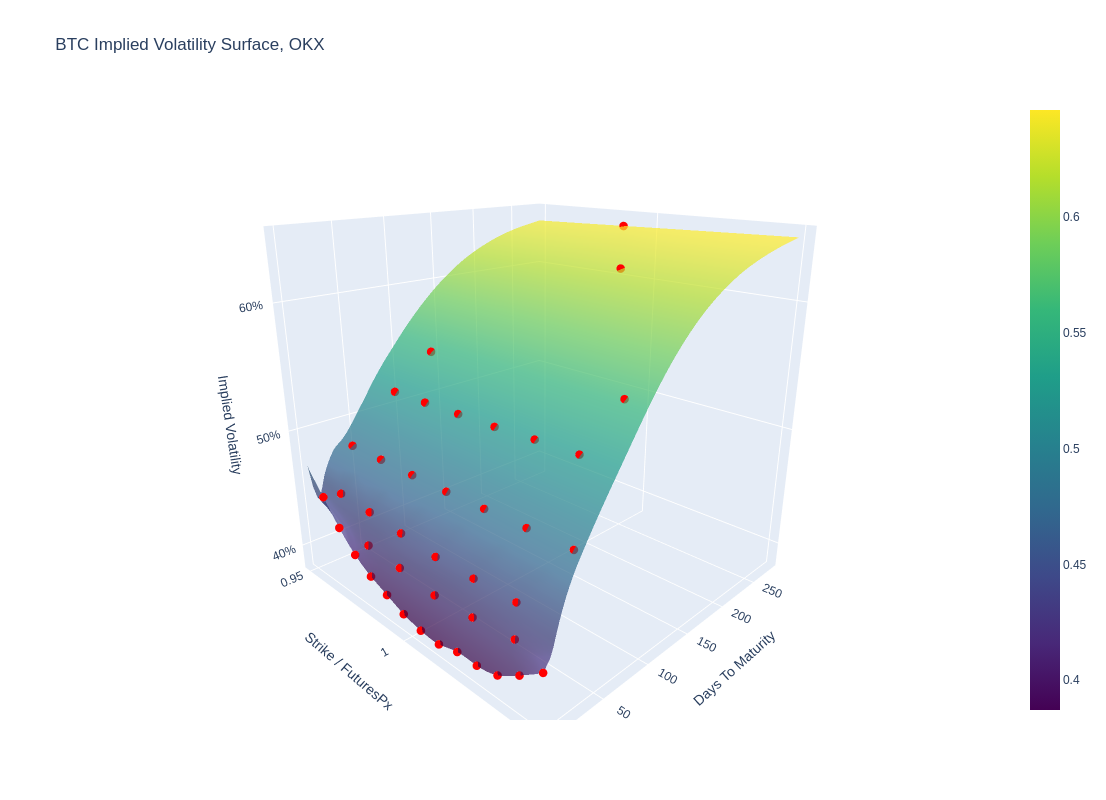

In [9]:
import plotly.graph_objects as go

def plot_iv_surf_plotly(x, y, z, x2=None, y2=None, z2=None, label=''):
    fig = go.Figure()

    # Create the surface plot
    fig.add_trace(go.Surface(x=x, y=y, z=z, colorscale='Viridis', opacity=0.7))

    # Add scatter points if provided
    if x2 is not None and y2 is not None and z2 is not None:
        fig.add_trace(go.Scatter3d(
            x=x2,
            y=y2,
            z=z2,
            mode='markers',
            marker=dict(size=5, color='red', symbol='circle'),
            name=label
        ))

    fig.update_layout(
        title='BTC Implied Volatility Surface, OKX',
        scene=dict(
            xaxis_title='Strike / FuturesPx',
            yaxis_title='Days To Maturity',
            zaxis_title='Implied Volatility',
            zaxis=dict(tickformat=".0%")
        ),
        legend=dict(x=0, y=1),
        width=1200,  # Set the width of the plot
        height=800   # Set the height of the plot
    )

    fig.show()

# Interpolate implied volatility using a cubic spline
x = data['moneyness']
y = data['days_to_maturity']
z = data['mark_iv'] / 100

X, Y = np.meshgrid(np.linspace(.95, 1.05, 99), np.linspace(1, np.max(y), 100))
Z = interpolate.griddata(np.array([x, y]).T, np.array(z), (X, Y), method='cubic')

xyz = pd.DataFrame({'x': x, 'y': y, 'z': z})
xyz = xyz.query('x > 0.95 & x < 1.05')

plot_iv_surf_plotly(X, Y, Z, xyz['x'], xyz['y'], xyz['z'], 'Observed IV')

iv_df = pd.DataFrame(Z, index=np.linspace(10, np.max(y), 100), columns=np.linspace(.95, 1.05, 99))
